<a href="https://colab.research.google.com/github/elijahcw-git/Capstone/blob/main/Logistic_Regression_LAPD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The data source for LA crime from 2020: 2024
  * https://data.lacity.org/Public-Safety/Crime-Data-from-2020-to-Present/2nrs-mtv8/about_data

Previous work:
  * Kaggle: https://www.kaggle.com/datasets/hemil26/crime-in-los-angeles/code

  * EDA with R: https://www.kaggle.com/code/teresawu726/eda-prediction-of-los-angeles-crime-by#Crime-prediction

  * LA Crime Analysis: https://www.kaggle.com/code/shayalvaghasiya/los-angeles-crimes-analysis
  

These questions guide our analysis and are central to our project's objectives:
What are the hotspots of crime occurrences in LA, and how can we predict the types of crime?
We propose to investigate factors such as time of day, day of the week, geographical locations, and types of crime in LA.

2-What role do victim demographics play in crime prediction?
We intend to explore the relationships between demographic variables and crime types to identify potential patterns or trends before they occur.

3-Do specific weather conditions in LA influence crime patterns and frequencies?We propose to construct a model to explore the correlation between weather and crime, aiming to guide law enforcement in resource planning based on weather-related crime trends.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# !pip install category_encoders

In [2]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [3]:
#Import dataset:

clean_df = pd.read_csv('clean_df_1Mar2024.csv')
print(clean_df.shape)

(2883802, 26)


In [4]:
# clean_df['Vict_Descent'].unique()

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
# # Print data shape
# print(f"Dataset shape: {clean_df.shape}\n")

# missing_values = clean_df.isnull().sum()
# percentage_missing = (missing_values / len(clean_df)) * 100
# unique_values = clean_df.nunique()  # Count unique values in each column

# # Creating a DataFrame to display data type, missing values, percentage of missing values, and number of unique values
# summary_df = pd.DataFrame({
#     'Data_type': clean_df.dtypes,
#     'Missing': missing_values,
#     '%_Missing': percentage_missing,
#     'Unique_values': unique_values  # Adding the unique values count
# })

# print(summary_df)

In [7]:
# Existing data cleaning steps
# clean_df = clean_df[~((clean_df['LAT'] == 0) & (clean_df['LON'] == 0))]
# clean_df = clean_df[(clean_df['Avg_Windspeed'] <= 80) & (clean_df['Vict_Age'] <= 100)]
# clean_df['Vict_Sex'].fillna('Unknown', inplace=True)
# clean_df['Vict_Descent'].fillna('Unknown', inplace=True)
# clean_df['Total_Precipitation'].fillna(clean_df['Total_Precipitation'].median(), inplace=True)

# Function to categorize age into 3 numeric categories
def categorize_age(age):
    if age < 18:
        return 0  # Category for minors
    elif age <= 64:
        return 1  # Category for adults
    else:
        return 2  # Category for seniors

# Column for age categories
clean_df['Vict_Age_Category'] = clean_df['Vict_Age'].apply(categorize_age)

In [8]:
# columns_to_drop = ['Crm_Cd_1', 'Premis_Cd', 'Premis_Desc','Status', 'Status_Desc']
# clean_df.drop(columns=columns_to_drop, inplace=True)
# clean_df['Weapon_Reported'] = clean_df['Weapon_Used_Cd'].notna().astype(int)

In [9]:
# Display the unique value the number count of those unique value.

# for column in ['Part_1-2', 'Weapon_Reported','Vict_Sex','Vict_Age_Category']:
#   print(f"Unique values for {column}:")
#   unique_values = clean_df[column].unique()
#   for value in unique_values:
#     count = clean_df[clean_df[column] == value].shape[0]
#     print(f"  - {value}: {count}")

In [10]:
# Select the top 10 most frequent Crm_Cd
# top_10_crimes = clean_df['Crm_Cd'].value_counts().nlargest(10).index
df_top_10_crimes = clean_df
# # Filter the dataset to only include rows with the top 10 Crm_Cd
# df_top_10_crimes = clean_df[clean_df['Crm_Cd'].isin(top_10_crimes)]

# # Print the new dataset shape
# print(df_top_10_crimes.shape)


# Cleaning Data to top 10 crimes

In [11]:
data=df_top_10_crimes

# Convert 'Date_Rptd' and 'DATE_OCC' to datetime
data['Date_Rptd'] = pd.to_datetime(data['Date_Rptd'])
data['DATE_OCC'] = pd.to_datetime(data['DATE_OCC'])

# Extract day of week, month, and year from 'DATE_OCC'
data['Day_of_Week'] = data['DATE_OCC'].dt.dayofweek
data['Month'] = data['DATE_OCC'].dt.month
data['Year'] = data['DATE_OCC'].dt.year

# Drop the original 'Date_Rptd' and 'DATE_OCC' columns
data = data.drop(['Date_Rptd', 'DATE_OCC'], axis=1)

# Convert 'Vict_Sex' and 'Vict_Descent' to dummy variables
categorical_to_convert = ['Vict_Sex', 'Region_Ethnic_Origin']
data = pd.get_dummies(data, columns=categorical_to_convert, drop_first=True)
data['Day_of_Week'] = data['Day_of_Week'].astype('category')
data['Month'] = data['Month'].astype('category')
data['Year'] = data['Year'].astype('category')

# Create dummy variables for these columns
data = pd.get_dummies(data, columns=['Day_of_Week', 'Month', 'Year'], drop_first=True)


# We will not convert 'LOCATION' due to its high cardinality
data.drop(['LOCATION','Vict_Age_Category', 'Vict_Descent', 'DR_NO'], axis=1, inplace=True)

In [12]:
data.columns

Index(['TIME_OCC', 'AREA', 'AREA_NAME', 'Rpt_Dist_No', 'Part_1-2', 'Crm_Cd',
       'Crm_Cd_Desc', 'Vict_Age', 'LAT', 'LON', 'Avg_Temp', 'Avg_Dewpoint',
       'Avg_Humidity', 'Avg_Windspeed', 'Avg_Pressure', 'Total_Precipitation',
       'Crime_Category', 'Crime_Category_Code', 'Weapon_Reported',
       'Vict_Sex_M', 'Vict_Sex_X', 'Region_Ethnic_Origin_Black',
       'Region_Ethnic_Origin_Hispanic/Latin/Mexican',
       'Region_Ethnic_Origin_Other', 'Region_Ethnic_Origin_Unknown',
       'Region_Ethnic_Origin_White', 'Day_of_Week_1', 'Day_of_Week_2',
       'Day_of_Week_3', 'Day_of_Week_4', 'Day_of_Week_5', 'Day_of_Week_6',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12', 'Year_2011',
       'Year_2012', 'Year_2013', 'Year_2014', 'Year_2015', 'Year_2016',
       'Year_2017', 'Year_2018', 'Year_2019', 'Year_2020', 'Year_2021',
       'Year_2022', 'Year_2023'],
      dtype='object')

In [13]:
# Print data shape
print(f"Dataset shape: {data.shape}\n")

missing_values = data.isnull().sum()
percentage_missing = (missing_values / len(data)) * 100
unique_values = data.nunique()  # Count unique values in each column
non_missing_count = data.count()  # Count non-missing values in each column

# Creating a DataFrame to:
summary_df = pd.DataFrame({
    'Data_type': data.dtypes, # Display data type
    'Count': non_missing_count,  # Count of non-missing values
    'Missing': missing_values, # Missing values
    '%_Missing': percentage_missing, # Percentage of missing values
    'Unique_values': unique_values  # Unique values count
})

print(summary_df)


Dataset shape: (2883802, 56)

                                            Data_type    Count  Missing  \
TIME_OCC                                        int64  2883802        0   
AREA                                            int64  2883802        0   
AREA_NAME                                      object  2883802        0   
Rpt_Dist_No                                     int64  2883802        0   
Part_1-2                                        int64  2883802        0   
Crm_Cd                                          int64  2883802        0   
Crm_Cd_Desc                                    object  2883802        0   
Vict_Age                                      float64  2883802        0   
LAT                                           float64  2883802        0   
LON                                           float64  2883802        0   
Avg_Temp                                      float64  2883802        0   
Avg_Dewpoint                                  float64  2883802        

In [14]:
data = data.drop(columns=['Crm_Cd_Desc', 'Crime_Category', 'Crm_Cd', 'AREA_NAME', 'Rpt_Dist_No', 'TIME_OCC',], axis = 0)

# Algorithms LR

In [15]:
# Separate the features and the target variable
X = data.drop('Crime_Category_Code', axis=1)  # Features
y = data['Crime_Category_Code']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Logistic Regression model
# log_reg = LogisticRegression(max_iter=1000)

# # Train the model
# log_reg.fit(X_train, y_train)

# # Make predictions on the testing set
# y_pred = log_reg.predict(X_test)

# # Calculate the accuracy of the model
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy of the Logistic Regression model: {accuracy * 100:.2f}%")


In [16]:
# coefficients = log_reg.coef_[0]

# # Map coefficients to features
# feature_names = X_train.columns
# feature_impact = pd.DataFrame({
#     'Feature': feature_names,
#     'Coefficient': coefficients
# }).sort_values(by='Coefficient', ascending=False)

# print(feature_impact)

In [17]:
from xgboost import XGBClassifier

In [18]:
xgb_model = XGBClassifier(n_estimators = 100, n_jobs=-1, use_label_encoder = False, eval_metric = 'mlogloss')

In [19]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, objective='multi:softprob', ...)

Accuracy: 0.7308
              precision    recall  f1-score   support

           0       0.70      0.91      0.79    121522
           1       0.47      0.56      0.51     41560
           2       0.77      0.49      0.60    115516
           3       0.52      0.45      0.49     26344
           4       0.54      0.25      0.34      5945
           5       0.95      0.91      0.93    201431
           6       0.45      0.63      0.53     53323
           7       0.53      0.03      0.06     11120

    accuracy                           0.73    576761
   macro avg       0.61      0.53      0.53    576761
weighted avg       0.75      0.73      0.72    576761



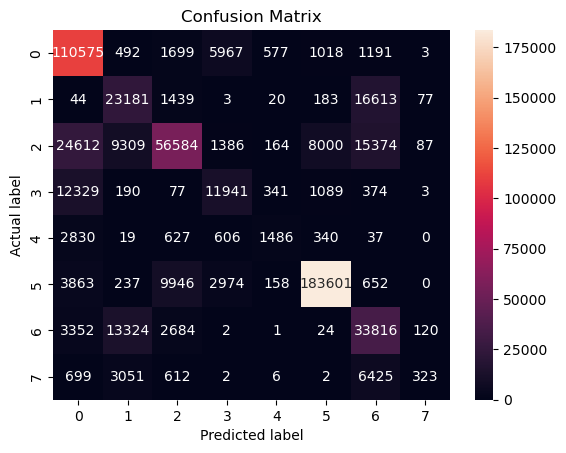

In [20]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions
y_pred = xgb_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification report
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [32]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier


In [33]:
param_grid = {
    'xgbclassifier__learning_rate': [0.01, 0.1, 0.2],  # or 'eta'
    'xgbclassifier__n_estimators': [100, 200],
    'xgbclassifier__max_depth': [3, 5, 7],
    'xgbclassifier__min_child_weight': [1, 3],
    'xgbclassifier__gamma': [0, 0.1],  # or 'min_split_loss'
    'xgbclassifier__subsample': [0.8, 1.0],
    'xgbclassifier__colsample_bytree': [0.8, 1.0],
}

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Assuming XGBClassifier is wrapped in a pipeline for preprocessing
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgbclassifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])


In [35]:
grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)


In [ ]:
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 288 candidates, totalling 864 fits


In [ ]:
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: ", grid_search.best_score_)


In [ ]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_accuracy:.4f}")


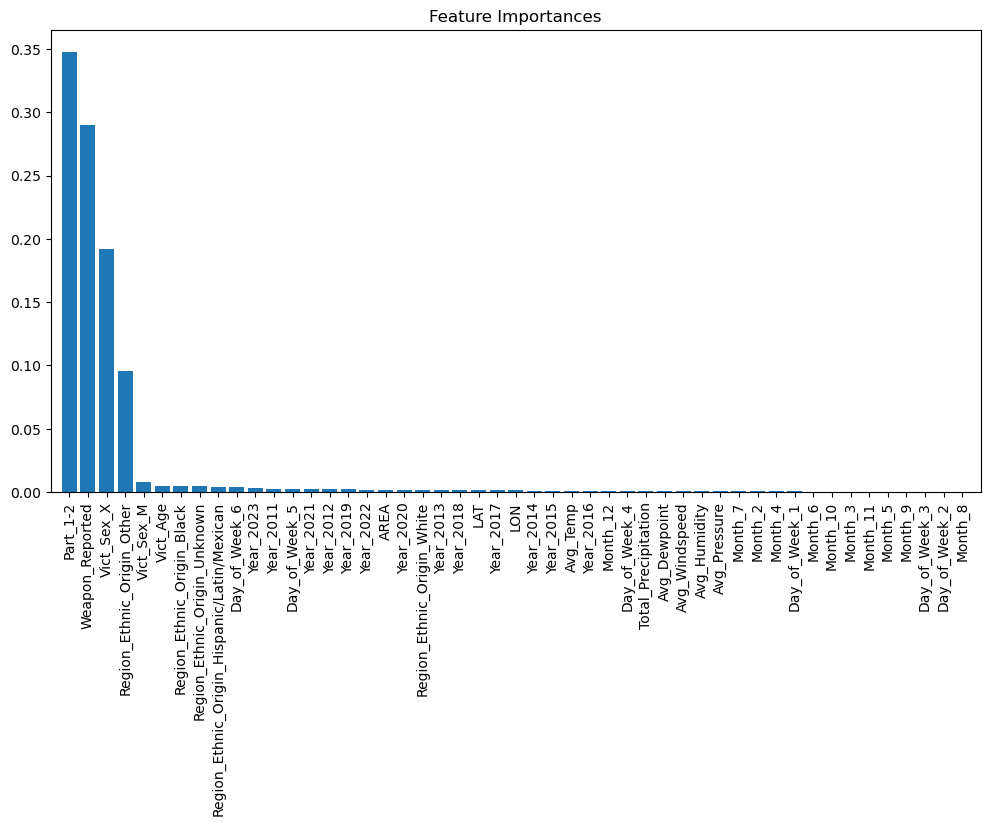

In [21]:
# Get feature importances
importances = xgb_model.feature_importances_

# Plot feature importances
features = X_train.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), features[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()


In [22]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(n_jobs=-1, random_state=42)

Accuracy: 0.7736
Precision: 0.6819
Recall: 0.6030
F1 Score: 0.6217


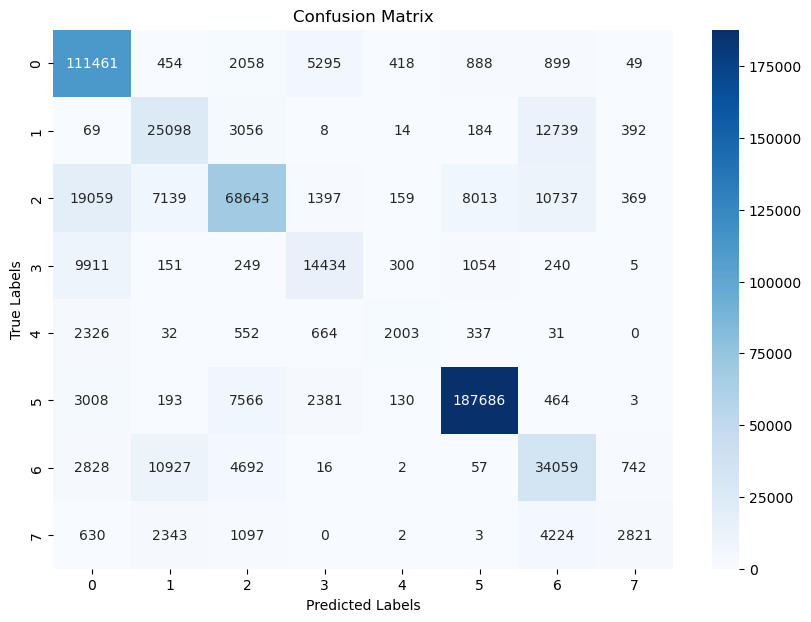

In [24]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = rf_model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')  # Use 'binary' for binary classification, 'macro' for multi-class
recall = recall_score(y_test, y_pred, average='macro')  # Use 'binary' for binary classification, 'macro' for multi-class
f1 = f1_score(y_test, y_pred, average='macro')  # Use 'binary' for binary classification, 'macro' for multi-class

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [26]:
 from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
# Create a pipeline with standardization and SGDClassifier
sgd_pipeline = make_pipeline(StandardScaler(), SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001, max_iter=1000, tol=1e-3))

# Fit the model
sgd_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_sgd = sgd_pipeline.predict(X_test)

# Calculate accuracy
accuracy_sgd = accuracy_score(y_test, y_pred_sgd)
print(f"Accuracy of the SGD-approximated SVM model: {accuracy_sgd * 100:.2f}%")


Accuracy of the SGD-approximated SVM model: 68.65%


In [27]:
svm_pipeline = make_pipeline(StandardScaler(), LinearSVC(dual=False, C=1.0, max_iter=1000))

# Fit the model
svm_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = svm_pipeline.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the Linear SVM model: {accuracy * 100:.2f}%")

Accuracy of the Linear SVM model: 70.12%


In [30]:
from sklearn.model_selection import GridSearchCV

# Define a pipeline with standardization and LinearSVC
svm_pipeline = make_pipeline(StandardScaler(), LinearSVC(dual=False, max_iter=10000))

# Parameters of the model to tune
param_grid = {
    'linearsvc__C': [0.01, 0.1, 1, 10, 100]
}

# Grid search with cross-validation
grid_search = GridSearchCV(svm_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters for LinearSVC:", grid_search.best_params_)
print(f"Best cross-validation accuracy: {grid_search.best_score_:.2f}%")


Best parameters for LinearSVC: {'linearsvc__C': 0.1}
Best cross-validation accuracy: 0.70%


In [31]:
# Create a pipeline with standardization and SGDClassifier
sgd_pipeline = make_pipeline(StandardScaler(), SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3))

# Parameters of the model to tune
param_grid_sgd = {
    'sgdclassifier__alpha': [0.0001, 0.001, 0.01, 0.1],
    'sgdclassifier__penalty': ['l2', 'l1', 'elasticnet'],
    'sgdclassifier__learning_rate': ['optimal', 'invscaling', 'adaptive'],
    'sgdclassifier__eta0': [0.01, 0.1]  # Only used if learning_rate is set to 'invscaling' or 'adaptive'
}

# Grid search with cross-validation
grid_search_sgd = GridSearchCV(sgd_pipeline, param_grid_sgd, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_sgd.fit(X_train, y_train)

print("Best parameters for SGDClassifier:", grid_search_sgd.best_params_)
print(f"Best cross-validation accuracy: {grid_search_sgd.best_score_:.2f}%")


Best parameters for SGDClassifier: {'sgdclassifier__alpha': 0.0001, 'sgdclassifier__eta0': 0.01, 'sgdclassifier__learning_rate': 'optimal', 'sgdclassifier__penalty': 'elasticnet'}
Best cross-validation accuracy: 0.69%
